#**Image Classification using Convolutional Neural Networks**

In [ ]:
__author__ = "Mohamad Radwan"
__email__ = "mohrad96@hotmail.com"

In [ ]:
#Install Objax
!pip --quiet install  objax
import objax

     |████████████████████████████████| 51kB 4.8MB/s 


In [ ]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random 
import matplotlib.pyplot as plt

##**Part 1. Building a CNN** 

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

In [ ]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
X_train.shape

(48000, 3, 32, 32)


Next we will construct a **Base Model**, which in our case is a small CNN.

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, we take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



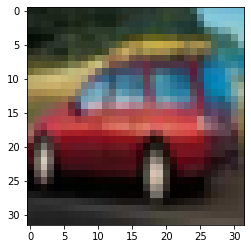

In [ ]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine.

In [ ]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)
print(my_image.shape)
#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now
print("Filter weights:", filter_weights)
print("Conv output:", Conv2d(my_image))
Convoluted_Image = Conv2d(my_image)
print("Conv output shape:", np.shape(Conv2d(my_image)))

(1, 3, 32, 32)
Filter weights: [[[[ 0.7304995   0.6803058 ]
   [-1.0113425  -0.19040492]
   [-0.3848219   0.6740011 ]]]]
Conv output: [[[[-0.10271908 -0.10010862 -0.09076816 ... -0.7420423  -0.73912483
    -0.7374622 ]
   [-0.12882358 -0.11180528 -0.11687267 ... -0.73105437 -0.7434611
    -0.7408506 ]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.6991137  -0.7174033
    -0.7156083 ]
   ...
   [-0.11485983 -0.10963893 -0.10963893 ... -0.11178758 -0.11439803
    -0.12222939]
   [-0.09658667 -0.09136578 -0.09136578 ... -0.1274503  -0.12483985
    -0.12483985]
   [-0.08614487 -0.08353443 -0.08614487 ... -0.16399662 -0.16138618
    -0.15355481]]

  [[ 0.10279882  0.0982345   0.08189839 ...  0.75253254  0.7320599
     0.7214626 ]
   [ 0.14844204  0.1263671   0.1275416  ...  0.77934486  0.7626404
     0.7580761 ]
   [ 0.15300636  0.12562042  0.15036322 ...  0.79253834  0.77845234
     0.775332  ]
   ...
   [ 0.20083015  0.1917015   0.1917015  ...  0.27218536  0.27674967
     0.29044265]
   [

**In the cells below, we create our own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and then show that our convolution routine returns the same value as Objax's.**

In [ ]:
def my_conv_net(my_image, initial_filter_weights):
  Hout = my_image.shape[2]-initial_filter_weights.shape[0]+1
  Wout = my_image.shape[3]-initial_filter_weights.shape[0]+1
  weights = initial_filter_weights
  my_conv_output = np.zeros((my_image.shape[0],initial_filter_weights.shape[3],Hout,Wout))
  for n in range(my_image.shape[0]):
    for c in range(initial_filter_weights.shape[3]):
      for h in range(Hout):
        for w in range(Wout):
          my_conv_output[n,c,h,w] = jn.dot(weights[:,:,:,c], my_image[n,:,h,w])
  
  return my_conv_output

In [ ]:
my_conv_output = my_conv_net(my_image, filter_weights)

In [ ]:
print((Convoluted_Image.shape == my_conv_output.shape))
print((Convoluted_Image == my_conv_output))

True
[[[[False  True  True ...  True False False]
   [ True False False ... False  True  True]
   [ True False  True ...  True  True False]
   ...
   [False False False ...  True  True False]
   [ True False False ... False  True  True]
   [False  True False ...  True False False]]

  [[ True False  True ... False  True  True]
   [ True  True  True ... False False  True]
   [ True  True  True ... False False  True]
   ...
   [False  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ... False  True  True]]]]


In [ ]:
print(my_conv_output)

[[[[-0.10271907 -0.10010862 -0.09076816 ... -0.7420423  -0.73912489
    -0.73746228]
   [-0.12882358 -0.11180527 -0.11687266 ... -0.73105443 -0.74346107
    -0.74085063]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.69911373 -0.71740329
    -0.71560836]
   ...
   [-0.11485984 -0.10963892 -0.10963892 ... -0.11178758 -0.11439803
    -0.12222938]
   [-0.09658667 -0.09136577 -0.09136577 ... -0.12745032 -0.12483985
    -0.12483985]
   [-0.08614486 -0.08353443 -0.08614486 ... -0.16399662 -0.16138616
    -0.15355483]]

  [[ 0.10279882  0.09823449  0.08189839 ...  0.75253248  0.7320599
     0.72146261]
   [ 0.14844204  0.12636711  0.1275416  ...  0.7793448   0.76264036
     0.75807607]
   [ 0.15300636  0.12562042  0.15036322 ...  0.7925384   0.7784524
     0.77533197]
   ...
   [ 0.20083013  0.1917015   0.1917015  ...  0.27218536  0.27674967
     0.29044265]
   [ 0.1688799   0.15975127  0.15975127 ...  0.29957128  0.29500696
     0.29500696]
   [ 0.15062262  0.14605829  0.15062262 ...  0.3634

Comparing my convoluted output and objax's convoluted output we can see that they are equal, there are minor differences possibly due to differences in rounding and approximations of the calculations between objax's convolution routine and mine.

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Calling .mean((2,3)) rearranges the output of our convolution routine.

In [ ]:
#Check that .mean((2,3)) rearranges the image
my_conv_output.mean((2,3))
my_conv_output.mean((2,3)).shape

(1, 2)

Take our rearranged output and feed it into a linear layer of appropriate size. 

**Implementing the linear layer using one line of code and showing that it provides the same value as Objax's own linear layer.** 



In [ ]:
#Objax
Linear_Layer = objax.nn.Linear(my_conv_output.mean((2,3)).shape[1], 1)
Y = Linear_Layer(my_conv_output.mean((2,3)))
w = Linear_Layer.w.value
b = Linear_Layer.b.value
print(Y)

[[0.03471544]]


In [ ]:
#Manually
Y_manual = jn.dot(my_conv_output.mean((2,3)), w) + b
Y_manual

DeviceArray([[0.03471544]], dtype=float32)

Objax's Linear layer output and my manual linear layer output are equal.

##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. 

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value = params.value - lr*grad

    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:(it+np.minimum(BATCH,X_train.shape[0]-it))]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(100*train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:(it+np.minimum(BATCH,X_valid.shape[0]-it))]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(100*val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))


  print("Base model: Max Validation Accuracy: ",round(max(val_acc_epoch),3),"% at epoch ", val_acc_epoch.index(max(val_acc_epoch))+1)
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.88 Validation Accuracy 10.03
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 9.78 Validation Accuracy 10.02
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 9.90 Validation Accuracy 10.32
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.52 Validation Accuracy 10.58
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.49 Validation Accuracy 11.25
Epoch 0006  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 10.77
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 11.62
Epoch 0008  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.50 Validation Accuracy 12.08
Epoch 0009  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 11.84 Validation Accuracy 12.25
Epoch 0010  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 12.33 Validatio

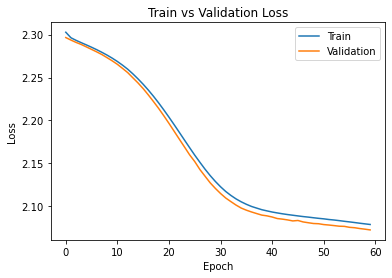

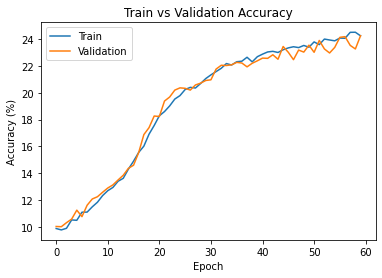

In [ ]:
train(EPOCHS = 60)

**Next, we optimize the base model by including 4 tunable hyperparamters which are BATCH, LEARNING_RATE, Nb_Outputs_ConvolutionLayer1, Nb_Convolution_Layers.**

In [ ]:
def train_4Hyperparameters(EPOCHS, BATCH, LEARNING_RATE, Nb_Outputs_ConvolutionLayer1, Nb_Convolution_Layers, ModelName, X_train, X_valid, X_test, Y_train, Y_valid, Y_test):
  class ConvNetUpdated(objax.Module):
    def __init__(self, Nb_Outputs_ConvolutionLayer1 = Nb_Outputs_ConvolutionLayer1, Nb_Convolution_Layers = Nb_Convolution_Layers, number_of_channels = 3, number_of_classes = 10):
      self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, Nb_Outputs_ConvolutionLayer1, 2), objax.functional.relu])
      n = 1
      self.conv = []
      for i in range(Nb_Convolution_Layers - 1):
        self.conv.append(objax.nn.Sequential([objax.nn.Conv2D(n*Nb_Outputs_ConvolutionLayer1, 2*n*Nb_Outputs_ConvolutionLayer1, 2), objax.functional.relu]))
        n = n*2
      self.linear = objax.nn.Linear(n*Nb_Outputs_ConvolutionLayer1, number_of_classes)
     

    def __call__(self, x):
      if Nb_Convolution_Layers == 1:
        x = self.conv_1(x)
        x = x.mean((2,3)) #<--- global average pooling 
        x = self.linear(x)
      elif Nb_Convolution_Layers > 1:
        x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
        for i in range(Nb_Convolution_Layers - 1):
          if (i < Nb_Convolution_Layers - 2):
            x = objax.functional.max_pool_2d(self.conv[i](x), 2, 2)
          else:
            x = self.conv[i](x)
            x = x.mean((2,3)) #<--- global average pooling 
            x = self.linear(x)
      return x

  #The following line creates the CNN
  model = ConvNetUpdated()

  def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

  #Define a prediction function
  predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

  #Create an object that can be used to calculate the gradient and value of loss_function
  gv= objax.GradValues(loss_function, model.vars())

  #Create an object that can be used to provide trainable variables in the model
  tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

  #Training routine
  def train_op(x, y, learning_rate):
      lr = learning_rate
      gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
      #next we update the trainable parameter using SGD and similar procedure
      for grad, params in zip(gradient, tv.vars()):
        params.value = params.value - lr*grad

      return loss_value                      # return loss value

  #make train_op (much) faster using JIT compilation
  train_op = objax.Jit(train_op, gv.vars() + tv.vars())


  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:(it+np.minimum(BATCH,X_train.shape[0]-it))]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(100*train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:(it+np.minimum(BATCH,X_valid.shape[0]-it))]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(100*val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])
      
      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))


  #Printing the epoch that has maximum validation accuracy
  print(ModelName+": Max Validation Accuracy: ",round(max(val_acc_epoch),3),"% at epoch ", val_acc_epoch.index(max(val_acc_epoch))+1)

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()
  
  #Storing Test Accuracy
  test_prediction = predict(X_test).argmax(1)
  test_acc = 100*((np.array(test_prediction).flatten() == Y_test).sum())/X_test.shape[0]
  return round(test_acc,3)

Trying 2 different models with different hyperparamter sets.

Epoch 0001  Training Loss 2.26 Validation Loss 2.19 Training Accuracy 15.95 Validation Accuracy 20.00
Epoch 0002  Training Loss 2.14 Validation Loss 2.09 Training Accuracy 21.76 Validation Accuracy 21.58
Epoch 0003  Training Loss 2.09 Validation Loss 2.07 Training Accuracy 23.96 Validation Accuracy 21.87
Epoch 0004  Training Loss 2.07 Validation Loss 2.05 Training Accuracy 25.18 Validation Accuracy 24.87
Epoch 0005  Training Loss 2.04 Validation Loss 2.03 Training Accuracy 26.42 Validation Accuracy 25.13
Epoch 0006  Training Loss 2.02 Validation Loss 2.01 Training Accuracy 27.45 Validation Accuracy 26.08
Epoch 0007  Training Loss 2.00 Validation Loss 1.99 Training Accuracy 28.37 Validation Accuracy 28.33
Epoch 0008  Training Loss 1.98 Validation Loss 1.97 Training Accuracy 29.30 Validation Accuracy 27.53
Epoch 0009  Training Loss 1.96 Validation Loss 1.95 Training Accuracy 30.26 Validation Accuracy 29.82
Epoch 0010  Training Loss 1.94 Validation Loss 1.93 Training Accuracy 31.33 Valida

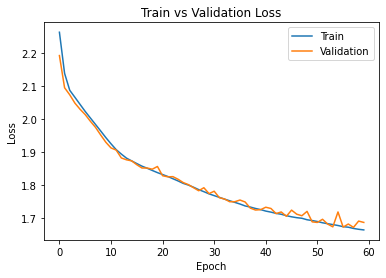

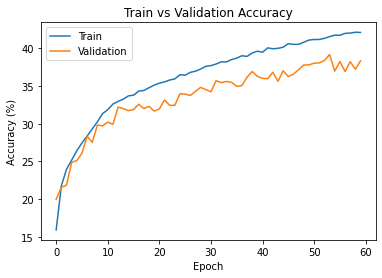

In [ ]:
M1_Testing_Accuracy = train_4Hyperparameters(EPOCHS = 60, BATCH = 24, LEARNING_RATE = 0.03, Nb_Outputs_ConvolutionLayer1 = 16, Nb_Convolution_Layers = 2, 
                                             ModelName = 'M1', X_train = X_train, X_valid = X_valid, X_test = X_test, Y_train = Y_train, Y_valid = Y_valid, Y_test = Y_test)

Epoch 0001  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 13.60 Validation Accuracy 17.27
Epoch 0002  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 17.25 Validation Accuracy 17.62
Epoch 0003  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 18.06 Validation Accuracy 18.43
Epoch 0004  Training Loss 2.25 Validation Loss 2.23 Training Accuracy 19.30 Validation Accuracy 20.78
Epoch 0005  Training Loss 2.21 Validation Loss 2.20 Training Accuracy 21.15 Validation Accuracy 21.80
Epoch 0006  Training Loss 2.18 Validation Loss 2.16 Training Accuracy 21.94 Validation Accuracy 22.05
Epoch 0007  Training Loss 2.14 Validation Loss 2.13 Training Accuracy 23.24 Validation Accuracy 22.63
Epoch 0008  Training Loss 2.11 Validation Loss 2.10 Training Accuracy 23.96 Validation Accuracy 24.35
Epoch 0009  Training Loss 2.09 Validation Loss 2.08 Training Accuracy 24.98 Validation Accuracy 24.03
Epoch 0010  Training Loss 2.07 Validation Loss 2.07 Training Accuracy 26.15 Valida

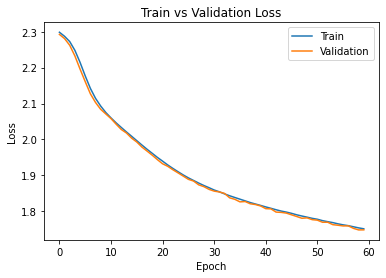

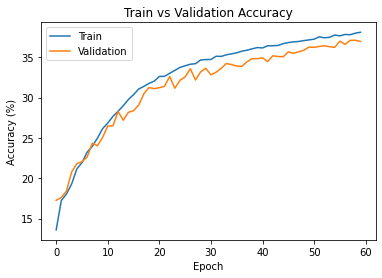

In [ ]:
M2_Testing_Accuracy = train_4Hyperparameters(EPOCHS = 60, BATCH = 40, LEARNING_RATE = 0.01, Nb_Outputs_ConvolutionLayer1 = 20, Nb_Convolution_Layers = 3, 
                                             ModelName = 'M2', X_train = X_train, X_valid = X_valid, X_test = X_test, Y_train = Y_train, Y_valid = Y_valid, Y_test = Y_test)

In [ ]:
print("Testing Accuracy:", M1_Testing_Accuracy,'%')

Testing Accuracy: 38.433 %


##**Part 3. Trying Out a New Dataset**


Next we try out a new dataset called "cmaterdb". This dataset contains images of - Handwritten Bangla numerals - balanced dataset of total 6000 Bangla numerals (32x32 RGB coloured, 6000 images), each having 600 images per class(per digit). Handwritten Devanagari numerals - balanced dataset of total 3000 Devanagari numerals (32x32 RGB coloured, 3000 images), each having 300 images per class(per digit). Handwritten Telugu numerals - balanced dataset of total 3000 Telugu numerals (32x32 RGB coloured, 3000 images), each having 300 images per class(per digit).

In [ ]:
numerals_data = tfds.load('cmaterdb', as_supervised = True)
numerals_train, numerals_test = numerals_data['train'], numerals_data['test']
X_train1 = np.zeros((5000, 32, 32, 3))
Y_train1 = np.zeros((5000,1))
X_test1 = np.zeros((1000, 32, 32, 3))
Y_test1 = np.zeros((1000,1))
i=0
for image, label in numerals_train:
  X_train1[i] = image
  Y_train1[i] = label
  i = i+1
i=0
for image, label in numerals_test:
  X_test1[i] = image
  Y_test1[i] = label
  i = i+1

In [ ]:
X_train1 = X_train1.transpose(0, 3, 1, 2) / 255.0
Y_train1 = Y_train1.flatten()
X_test1 = X_test1.transpose(0, 3, 1, 2) / 255.0
Y_test1 = Y_test1.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data1 = np.concatenate([X_train1, X_test1], axis = 0)
Y_data1 = np.concatenate([Y_train1, Y_test1], axis = 0)

N1 = np.arange(len(X_data1))
np.random.shuffle(N1)
X_data1 = X_data1[N1]
Y_data1 = Y_data1[N1]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio1 = 0.80
valid_ratio1 = 0.1
n_train1 = int(len(X_data1) * train_ratio1)
n_valid1 = int(len(X_data1) * valid_ratio1)

X_train1, X_valid1, X_test1 = X_data1[:n_train1], X_data1[n_train1:n_train1+n_valid1], X_data1[n_train1+n_valid1:]
Y_train1, Y_valid1, Y_test1 = Y_data1[:n_train1], Y_data1[n_train1:n_train1+n_valid1], Y_data1[n_train1+n_valid1:]

Epoch 0001  Training Loss 2.39 Validation Loss 2.33 Training Accuracy 9.56 Validation Accuracy 7.83
Epoch 0002  Training Loss 2.33 Validation Loss 2.31 Training Accuracy 10.17 Validation Accuracy 9.33
Epoch 0003  Training Loss 2.31 Validation Loss 2.31 Training Accuracy 11.27 Validation Accuracy 10.17
Epoch 0004  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 12.62 Validation Accuracy 10.83
Epoch 0005  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 12.96 Validation Accuracy 10.50
Epoch 0006  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 13.48 Validation Accuracy 10.17
Epoch 0007  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 13.10 Validation Accuracy 10.17
Epoch 0008  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 12.88 Validation Accuracy 10.33
Epoch 0009  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 13.58 Validation Accuracy 11.00
Epoch 0010  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 12.31 Validatio

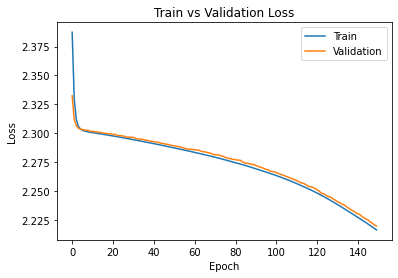

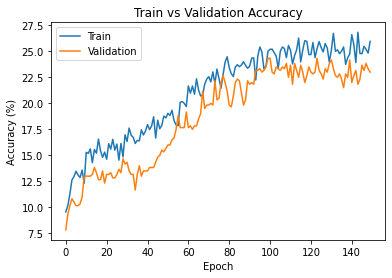

In [ ]:
Testing_Accuracy_Base_Model = train_4Hyperparameters(EPOCHS = 150, BATCH = 10, LEARNING_RATE = 1e-3, Nb_Outputs_ConvolutionLayer1 = 16, Nb_Convolution_Layers = 2, 
                                                     ModelName = "BaseModel", X_train = X_train1, X_valid = X_valid1, X_test = X_test1, Y_train = Y_train1.astype(int), Y_valid = Y_valid1.astype(int), Y_test = Y_test1.astype(int))

Epoch 0001  Training Loss 2.32 Validation Loss 2.30 Training Accuracy 9.92 Validation Accuracy 5.50
Epoch 0002  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 13.27 Validation Accuracy 7.50
Epoch 0003  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 14.17 Validation Accuracy 10.83
Epoch 0004  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 15.52 Validation Accuracy 8.83
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 18.04 Validation Accuracy 12.17
Epoch 0006  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 18.88 Validation Accuracy 14.33
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 20.75 Validation Accuracy 17.50
Epoch 0008  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 22.21 Validation Accuracy 21.50
Epoch 0009  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 22.85 Validation Accuracy 14.00
Epoch 0010  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 24.17 Validation

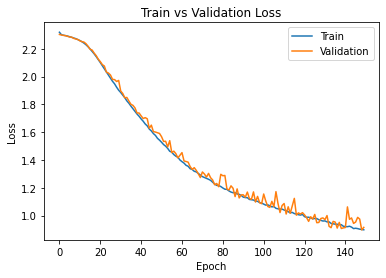

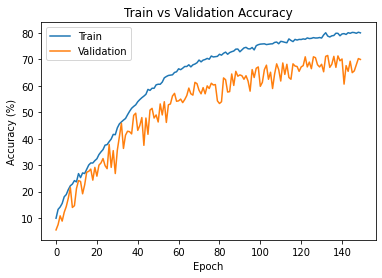

In [ ]:
Testing_Accuracy_M = train_4Hyperparameters(EPOCHS = 150, BATCH = 10, LEARNING_RATE = 1e-2, Nb_Outputs_ConvolutionLayer1 = 16, Nb_Convolution_Layers = 3, 
                                                     ModelName = "M", X_train = X_train1, X_valid = X_valid1, X_test = X_test1, Y_train = Y_train1.astype(int), Y_valid = Y_valid1.astype(int), Y_test = Y_test1.astype(int))

In [ ]:
print("Testing Accuracy:", Testing_Accuracy_M,'%')

Testing Accuracy: 67.333 %


##**Part 4. Open-Ended Exploration**

Question: How do Hyperparamters interact?

Epoch 0001  Training Loss 2.37 Validation Loss 2.32 Training Accuracy 9.94 Validation Accuracy 12.67
Epoch 0002  Training Loss 2.33 Validation Loss 2.31 Training Accuracy 10.77 Validation Accuracy 10.17
Epoch 0003  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 10.44 Validation Accuracy 10.17
Epoch 0004  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 10.81 Validation Accuracy 10.17
Epoch 0005  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.77 Validation Accuracy 9.67
Epoch 0006  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.77 Validation Accuracy 9.00
Epoch 0007  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.81 Validation Accuracy 8.83
Epoch 0008  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.21 Validation Accuracy 10.00
Epoch 0009  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.48 Validation Accuracy 9.50
Epoch 0010  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 8.73 Validation Accur

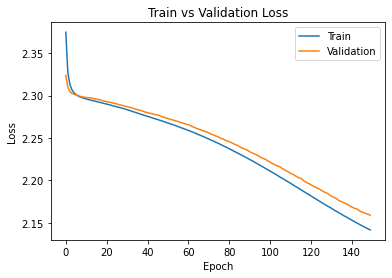

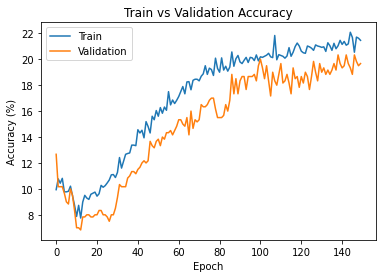

In [ ]:
Testing_Accuracy_Base = train_4Hyperparameters(EPOCHS = 150, BATCH = 32, LEARNING_RATE = 5e-3, Nb_Outputs_ConvolutionLayer1 = 16, Nb_Convolution_Layers = 1, 
                                                     ModelName = "Base", X_train = X_train1, X_valid = X_valid1, X_test = X_test1, Y_train = Y_train1.astype(int), Y_valid = Y_valid1.astype(int), Y_test = Y_test1.astype(int))

Epoch 0001  Training Loss 2.33 Validation Loss 2.32 Training Accuracy 10.35 Validation Accuracy 8.67
Epoch 0002  Training Loss 2.31 Validation Loss 2.31 Training Accuracy 10.35 Validation Accuracy 8.67
Epoch 0003  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.29 Validation Accuracy 8.67
Epoch 0004  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.35 Validation Accuracy 8.67
Epoch 0005  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.40 Validation Accuracy 9.17
Epoch 0006  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.21 Validation Accuracy 8.83
Epoch 0007  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.92 Validation Accuracy 8.83
Epoch 0008  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.23 Validation Accuracy 8.50
Epoch 0009  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.85 Validation Accuracy 8.67
Epoch 0010  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.77 Validation Accu

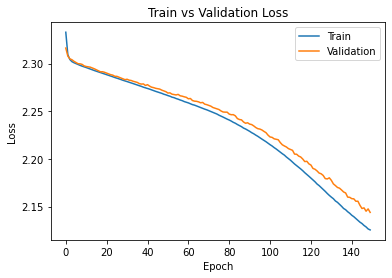

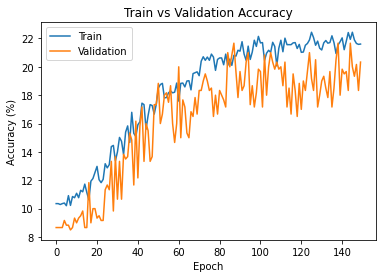

In [ ]:
#Batch
M1_Testing_Accuracy = train_4Hyperparameters(EPOCHS = 150, BATCH = 16, LEARNING_RATE = 5e-3, Nb_Outputs_ConvolutionLayer1 = 16, Nb_Convolution_Layers = 1, 
                                                     ModelName = "M1", X_train = X_train1, X_valid = X_valid1, X_test = X_test1, Y_train = Y_train1.astype(int), Y_valid = Y_valid1.astype(int), Y_test = Y_test1.astype(int))

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.98 Validation Accuracy 8.83
Epoch 0002  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 13.17 Validation Accuracy 9.33
Epoch 0003  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 14.48 Validation Accuracy 13.00
Epoch 0004  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 16.62 Validation Accuracy 16.67
Epoch 0005  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 17.90 Validation Accuracy 15.50
Epoch 0006  Training Loss 2.26 Validation Loss 2.26 Training Accuracy 19.58 Validation Accuracy 15.33
Epoch 0007  Training Loss 2.25 Validation Loss 2.24 Training Accuracy 19.29 Validation Accuracy 19.50
Epoch 0008  Training Loss 2.24 Validation Loss 2.24 Training Accuracy 20.19 Validation Accuracy 15.50
Epoch 0009  Training Loss 2.22 Validation Loss 2.22 Training Accuracy 20.98 Validation Accuracy 18.33
Epoch 0010  Training Loss 2.21 Validation Loss 2.21 Training Accuracy 21.33 Validati

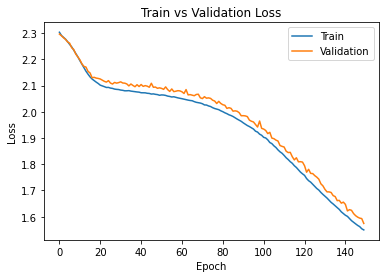

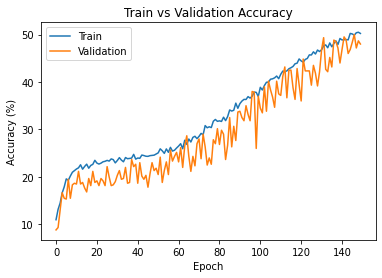

In [ ]:
#Learning Rate
M2_Testing_Accuracy = train_4Hyperparameters(EPOCHS = 150, BATCH = 32, LEARNING_RATE = 5e-2, Nb_Outputs_ConvolutionLayer1 = 16, Nb_Convolution_Layers = 1, 
                                                     ModelName = "M2", X_train = X_train1, X_valid = X_valid1, X_test = X_test1, Y_train = Y_train1.astype(int), Y_valid = Y_valid1.astype(int), Y_test = Y_test1.astype(int))

Epoch 0001  Training Loss 2.30 Validation Loss 2.28 Training Accuracy 14.56 Validation Accuracy 10.50
Epoch 0002  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 16.52 Validation Accuracy 15.83
Epoch 0003  Training Loss 2.26 Validation Loss 2.27 Training Accuracy 19.48 Validation Accuracy 13.00
Epoch 0004  Training Loss 2.24 Validation Loss 2.23 Training Accuracy 20.81 Validation Accuracy 18.83
Epoch 0005  Training Loss 2.22 Validation Loss 2.22 Training Accuracy 21.85 Validation Accuracy 17.67
Epoch 0006  Training Loss 2.19 Validation Loss 2.18 Training Accuracy 22.31 Validation Accuracy 21.50
Epoch 0007  Training Loss 2.16 Validation Loss 2.16 Training Accuracy 23.27 Validation Accuracy 18.33
Epoch 0008  Training Loss 2.14 Validation Loss 2.15 Training Accuracy 23.33 Validation Accuracy 20.50
Epoch 0009  Training Loss 2.12 Validation Loss 2.13 Training Accuracy 23.48 Validation Accuracy 20.50
Epoch 0010  Training Loss 2.12 Validation Loss 2.11 Training Accuracy 23.92 Valida

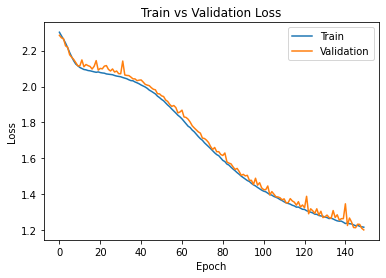

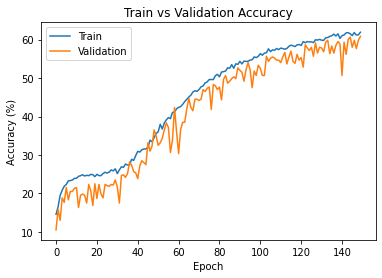

In [ ]:
#Batch and Learning rate
M3_Testing_Accuracy = train_4Hyperparameters(EPOCHS = 150, BATCH = 16, LEARNING_RATE = 5e-2, Nb_Outputs_ConvolutionLayer1 = 16, Nb_Convolution_Layers = 1, 
                                                     ModelName = "M3", X_train = X_train1, X_valid = X_valid1, X_test = X_test1, Y_train = Y_train1.astype(int), Y_valid = Y_valid1.astype(int), Y_test = Y_test1.astype(int))

Epoch 0001  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 18.40 Validation Accuracy 8.67
Epoch 0002  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 22.33 Validation Accuracy 14.83
Epoch 0003  Training Loss 2.22 Validation Loss 2.21 Training Accuracy 27.58 Validation Accuracy 19.00
Epoch 0004  Training Loss 2.17 Validation Loss 2.15 Training Accuracy 30.42 Validation Accuracy 17.50
Epoch 0005  Training Loss 2.11 Validation Loss 2.08 Training Accuracy 33.10 Validation Accuracy 31.67
Epoch 0006  Training Loss 2.06 Validation Loss 2.07 Training Accuracy 33.58 Validation Accuracy 22.33
Epoch 0007  Training Loss 2.01 Validation Loss 2.01 Training Accuracy 35.69 Validation Accuracy 25.50
Epoch 0008  Training Loss 1.97 Validation Loss 1.98 Training Accuracy 37.56 Validation Accuracy 27.00
Epoch 0009  Training Loss 1.94 Validation Loss 1.96 Training Accuracy 39.02 Validation Accuracy 30.33
Epoch 0010  Training Loss 1.91 Validation Loss 1.91 Training Accuracy 40.46 Validat

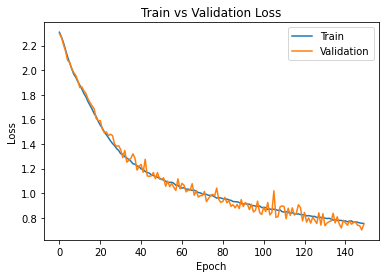

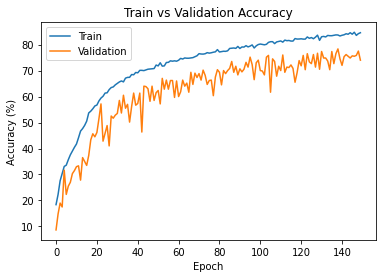

In [ ]:
#Base2
Testing_Accuracy_Base2 = train_4Hyperparameters(EPOCHS = 150, BATCH = 16, LEARNING_RATE = 5e-2, Nb_Outputs_ConvolutionLayer1 = 128, Nb_Convolution_Layers = 2, 
                                                     ModelName = "Base2", X_train = X_train1, X_valid = X_valid1, X_test = X_test1, Y_train = Y_train1.astype(int), Y_valid = Y_valid1.astype(int), Y_test = Y_test1.astype(int))

Epoch 0001  Training Loss 2.34 Validation Loss 2.27 Training Accuracy 23.98 Validation Accuracy 16.67
Epoch 0002  Training Loss 2.25 Validation Loss 2.19 Training Accuracy 29.46 Validation Accuracy 24.67
Epoch 0003  Training Loss 2.18 Validation Loss 2.18 Training Accuracy 32.79 Validation Accuracy 19.33
Epoch 0004  Training Loss 2.11 Validation Loss 2.12 Training Accuracy 34.40 Validation Accuracy 22.67
Epoch 0005  Training Loss 2.05 Validation Loss 2.02 Training Accuracy 36.98 Validation Accuracy 36.67
Epoch 0006  Training Loss 2.00 Validation Loss 2.00 Training Accuracy 38.96 Validation Accuracy 27.67
Epoch 0007  Training Loss 1.95 Validation Loss 1.95 Training Accuracy 40.04 Validation Accuracy 29.00
Epoch 0008  Training Loss 1.91 Validation Loss 1.90 Training Accuracy 42.35 Validation Accuracy 27.83
Epoch 0009  Training Loss 1.87 Validation Loss 1.87 Training Accuracy 42.69 Validation Accuracy 32.83
Epoch 0010  Training Loss 1.84 Validation Loss 1.87 Training Accuracy 44.83 Valida

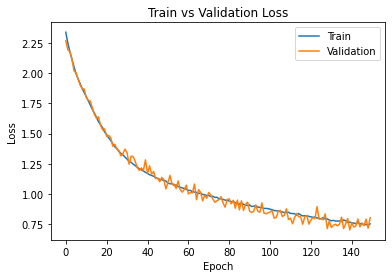

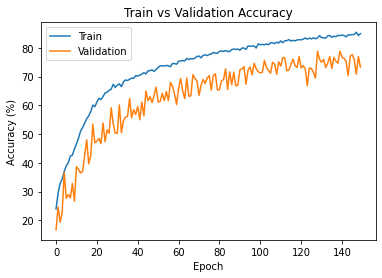

In [ ]:
#Number of outputs of convolution layer 1
M4_Testing_Accuracy = train_4Hyperparameters(EPOCHS = 150, BATCH = 16, LEARNING_RATE = 5e-2, Nb_Outputs_ConvolutionLayer1 = 256, Nb_Convolution_Layers = 2, 
                                                     ModelName = "M4", X_train = X_train1, X_valid = X_valid1, X_test = X_test1, Y_train = Y_train1.astype(int), Y_valid = Y_valid1.astype(int), Y_test = Y_test1.astype(int))

Epoch 0001  Training Loss 2.30 Validation Loss 2.28 Training Accuracy 23.58 Validation Accuracy 13.00
Epoch 0002  Training Loss 2.22 Validation Loss 2.24 Training Accuracy 29.08 Validation Accuracy 17.83
Epoch 0003  Training Loss 2.15 Validation Loss 2.13 Training Accuracy 34.48 Validation Accuracy 16.83
Epoch 0004  Training Loss 2.07 Validation Loss 2.06 Training Accuracy 37.29 Validation Accuracy 28.00
Epoch 0005  Training Loss 2.01 Validation Loss 1.99 Training Accuracy 41.50 Validation Accuracy 26.67
Epoch 0006  Training Loss 1.94 Validation Loss 1.93 Training Accuracy 44.21 Validation Accuracy 34.00
Epoch 0007  Training Loss 1.89 Validation Loss 1.85 Training Accuracy 47.54 Validation Accuracy 37.67
Epoch 0008  Training Loss 1.83 Validation Loss 1.80 Training Accuracy 50.02 Validation Accuracy 38.83
Epoch 0009  Training Loss 1.78 Validation Loss 1.78 Training Accuracy 53.71 Validation Accuracy 30.33
Epoch 0010  Training Loss 1.72 Validation Loss 1.70 Training Accuracy 56.12 Valida

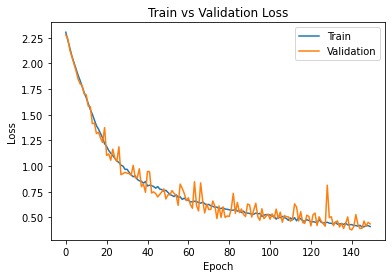

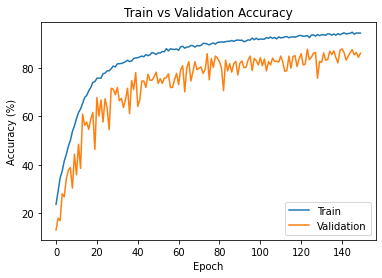

In [ ]:
#Number of convolution layers
M5_Testing_Accuracy = train_4Hyperparameters(EPOCHS = 150, BATCH = 16, LEARNING_RATE = 5e-2, Nb_Outputs_ConvolutionLayer1 = 128, Nb_Convolution_Layers = 3, 
                                                     ModelName = "M5", X_train = X_train1, X_valid = X_valid1, X_test = X_test1, Y_train = Y_train1.astype(int), Y_valid = Y_valid1.astype(int), Y_test = Y_test1.astype(int))

Epoch 0001  Training Loss 2.33 Validation Loss 2.26 Training Accuracy 25.88 Validation Accuracy 10.33
Epoch 0002  Training Loss 2.22 Validation Loss 2.17 Training Accuracy 31.38 Validation Accuracy 29.17
Epoch 0003  Training Loss 2.13 Validation Loss 2.06 Training Accuracy 36.73 Validation Accuracy 30.17
Epoch 0004  Training Loss 2.04 Validation Loss 2.04 Training Accuracy 41.58 Validation Accuracy 28.67
Epoch 0005  Training Loss 1.96 Validation Loss 1.95 Training Accuracy 44.46 Validation Accuracy 31.17
Epoch 0006  Training Loss 1.89 Validation Loss 1.86 Training Accuracy 47.25 Validation Accuracy 41.17
Epoch 0007  Training Loss 1.83 Validation Loss 1.88 Training Accuracy 51.35 Validation Accuracy 27.83
Epoch 0008  Training Loss 1.76 Validation Loss 1.83 Training Accuracy 54.92 Validation Accuracy 29.00
Epoch 0009  Training Loss 1.70 Validation Loss 1.63 Training Accuracy 57.69 Validation Accuracy 52.83
Epoch 0010  Training Loss 1.64 Validation Loss 1.68 Training Accuracy 60.17 Valida

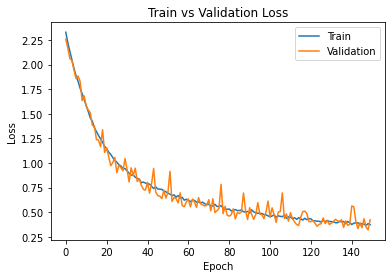

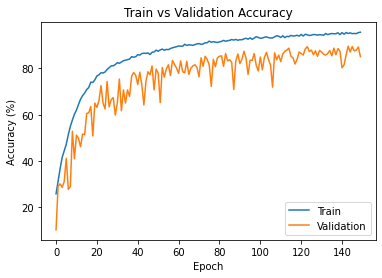

In [ ]:
#Number of outputs of convolution layer 1 and Number of convolution layers
M6_Testing_Accuracy = train_4Hyperparameters(EPOCHS = 150, BATCH = 16, LEARNING_RATE = 5e-2, Nb_Outputs_ConvolutionLayer1 = 256, Nb_Convolution_Layers = 3, 
                                                     ModelName = "M6", X_train = X_train1, X_valid = X_valid1, X_test = X_test1, Y_train = Y_train1.astype(int), Y_valid = Y_valid1.astype(int), Y_test = Y_test1.astype(int))

In [ ]:
print("Testing Accuracy:", M6_Testing_Accuracy,'%')

Testing Accuracy: 82.667 %
